# NI-VSM Domácí úkol 3

### Jakub Kučera - kucerj56

In [1]:
K = 11
L = 6
X = 19  # ((K*L*23) % 20) + 1
Y = 2  # ((X + ((K*5 + L*7) % 19)) % 20) + 1
file_1_path = "hw1-source/019.txt"
file_2_path = "hw1-source/002.txt"

In [2]:
from collections import Counter
from itertools import product
import math
import matplotlib.pylab as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.stats as st
import seaborn as sns

### 0. Z obou datových souborů načtěte texty k analýze. Pro každý text zvlášť zjistěte absolutní četnosti jednotlivých znaků (symbolů včetně mezery), které se v textech vyskytují. Dále předpokládejme, že první text je vygenerován z homogenního markovského řetězce s diskrétním časem.

Kod pro nacteni textu zkopiruji z 1./2. ukolu

In [3]:
def load_text(filename: str) -> str:
    with open(filename) as f1:
        file_contents = f1.read()
    # separate the first line with the book info from rest of the text
    info, text = file_contents.split('\n')
    return text

In [4]:
def calc_char_counts(filename: str):
    with open(filename) as f1:
        file_contents = f1.read()
    # separate the first line with the book info from rest of the text
    info, text = file_contents.split('\n')
    # Split the text into a list of separate characters
    list_of_characters = [*text]
    # total_characters_count = len(list_of_characters)
    # get number of occurrences for each character
    char_counter = Counter(list_of_characters)

    return dict(sorted(char_counter.items()))

In [5]:
text_1 = load_text(file_1_path)
file_1_chars_counts = calc_char_counts(file_1_path)
print(f"Cetnosti znaku 1. textu \n{file_1_chars_counts}")

text_2 = load_text(file_2_path)
file_2_chars_counts = calc_char_counts(file_2_path)
print(f"Cetnosti znaku 2. textu \n{file_2_chars_counts}")

Cetnosti znaku 1. textu 
{' ': 1169, 'a': 443, 'b': 95, 'c': 159, 'd': 178, 'e': 669, 'f': 96, 'g': 95, 'h': 326, 'i': 425, 'j': 11, 'k': 29, 'l': 239, 'm': 140, 'n': 382, 'o': 366, 'p': 147, 'q': 10, 'r': 298, 's': 374, 't': 487, 'u': 156, 'v': 55, 'w': 112, 'x': 21, 'y': 109, 'z': 11}
Cetnosti znaku 2. textu 
{' ': 1009, 'a': 343, 'b': 67, 'c': 74, 'd': 181, 'e': 478, 'f': 76, 'g': 85, 'h': 281, 'i': 264, 'j': 5, 'k': 47, 'l': 172, 'm': 74, 'n': 263, 'o': 313, 'p': 61, 'q': 2, 'r': 213, 's': 246, 't': 418, 'u': 115, 'v': 34, 'w': 131, 'x': 1, 'y': 73, 'z': 2}


Kontrola jestli oba texty obsahuji stejne znaky (dulezite na pozdejsi ukoly)

In [6]:
file_1_chars_counts.keys() == file_2_chars_counts.keys()

True

### (2b) Za předpokladu výše odhadněte matici přechodu markovského řetězce pro první text. Pro odhad matice přechodu vizte přednášku 17. Odhadnuté pravděpodobnosti přechodu vhodně graficky znázorněte, např. použitím heatmapy.

Nejprve si zjistim cetnosti prechodu z textu

In [7]:
def get_transitions(text: str) -> dict[str, int]:
    transitions: list[str] = []
    # iterate through text and put 2 following characters into the `transitions` list
    for i in range(len(text)-1):
        transitions.append(text[i:i+2])
    # get counts of all transitions and sort them alphabetically
    return sorted(Counter(transitions).items())

In [8]:
text_1_transitions = get_transitions(text_1)

Zkontroluji si, zda-li text obsahuje prechody mezi vsemi monznymi kombinacemi 2 znaku.

In [9]:
len(file_1_chars_counts.keys()) ** 2

729

In [10]:
len(text_1_transitions)

370

370 z 729 moznych kombinaci. Doplnim tedy nulove cetnosti (nakonec podle implementace konverze do Numpy pole nebylo potreba)

In [11]:
def get_all_empty_transitions(text: str) -> dict[str, int]:
    transitions: dict[str, int] = {}
    for a, b in product(set(text), repeat=2):
        transitions[a+b] = 0
    return transitions

In [12]:
text_1_all_transitions = get_all_empty_transitions(text_1)
text_1_all_transitions.update(text_1_transitions)
len(text_1_all_transitions)

729

Nyni si prevedu tyto namerene cetnosti do matice

Nejdrive si ale udelam "Slovnik" pro jednoduchou konverzi znaku na index v matici

In [13]:
def get_char_index_map(text: str):
    index_map: dict[str, int] = {}
    for n, c in enumerate(sorted(set(text))):
        index_map[c] = n
    return index_map
text_1_char_index_map = get_char_index_map(text_1)
print(text_1_char_index_map)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [14]:
def conv_transitions_2_matrix(all_transitions: dict[str, int], tr_map: dict[str, int]):
    # create empty array (filled with 0s) for all possible transitions
    transitions = np.zeros(shape=(27, 27))
    for c, n in all_transitions.items():
        # split transitions into seperate character. Ex.: 'ab' -> 'a' + 'b'
        c1, c2 = c
        # set count of given character transition in the matrix
        transitions[tr_map[c1], tr_map[c2]] = n
    return transitions

In [15]:
text_1_Nij = conv_transitions_2_matrix(text_1_all_transitions, text_1_char_index_map)
print(text_1_Nij)

[[  0. 137.  49.  43.  24.  36.  33.   7.  85. 103.   4.   6.  27.  50.
   28.  66.  72.   4.  28.  94. 157.  11.   8.  84.   0.  12.   1.]
 [ 35.   0.  11.  19.  18.   1.   1.  10.   0.  16.   1.   6.  35.  11.
  104.   0.  10.   0.  37.  45.  49.   3.  17.   0.   1.  13.   0.]
 [  1.   1.   1.   0.   0.  24.   0.   0.   0.   3.   6.   0.  24.   0.
    0.   8.   0.   0.   2.   2.   0.  12.   1.   0.   0.  10.   0.]
 [  8.  15.   0.   3.   0.  25.   0.   0.  28.   8.   0.   3.   7.   0.
    0.  25.   0.   1.  10.   4.  14.   5.   0.   0.   0.   3.   0.]
 [113.   4.   0.   0.   0.  20.   0.   0.   0.  14.   0.   0.   3.   0.
    0.   4.   0.   0.   4.   7.   0.   4.   2.   1.   0.   2.   0.]
 [211.  31.   0.  20.  44.  31.   6.   3.   0.   8.   0.   2.  23.  16.
   71.   0.   5.   3.  81.  48.  34.   2.  11.   2.  13.   3.   1.]
 [ 37.   5.   0.   0.   0.   6.   2.   0.   0.   5.   0.   0.   0.   0.
    0.  30.   0.   0.   5.   0.   3.   3.   0.   0.   0.   0.   0.]
 [ 24.   6.   0.   0

Pro odhad pravdepodobnosti prechodu, pouziju vztah a kod ze 6. cviceni

$P_{ij} = P(X_{n} = j | X_{n-1} = i) =  \frac{P(X_{n} = j ∧ X_{n-1} = i)}{P(X_{n-1} = i)}$

coz se da zjednodusit na (soucet cetnosti se pokrati)

$P_{ij} = \frac{n_{ij}}{n_{i*}}$

Spocitam si sdruzene cetnosti po radcich $n_{i*}$

In [16]:
ni_ = np.sum(text_1_Nij, axis = 1)
# ni_2 = np.dot(text_1_Nij, np.ones(27))
ni_

array([1169.,  443.,   95.,  159.,  178.,  669.,   96.,   95.,  326.,
        425.,   11.,   29.,  239.,  140.,  381.,  366.,  147.,   10.,
        298.,  374.,  487.,  156.,   55.,  112.,   21.,  109.,   11.])

Pro $n_{i*}$ si udelam inverzi vektoru po slozkach, abych pak mohl nasledne udelat obycejne maticove nasobeni

In [17]:
ni_inv = 1/ni_
ni_inv

array([0.00085543, 0.00225734, 0.01052632, 0.00628931, 0.00561798,
       0.00149477, 0.01041667, 0.01052632, 0.00306748, 0.00235294,
       0.09090909, 0.03448276, 0.0041841 , 0.00714286, 0.00262467,
       0.00273224, 0.00680272, 0.1       , 0.0033557 , 0.0026738 ,
       0.00205339, 0.00641026, 0.01818182, 0.00892857, 0.04761905,
       0.00917431, 0.09090909])

Aby kazdny prvek z $n_{i*}$ byl pouze vynasoben s prislusnym radkem, tak si z tohoto vektoru udelam diagonalni matici W (prechozi inverzni krok jsem mohl udelat jako inverzi teto diag matice)

In [18]:
W = np.diag(ni_inv)

Nyni si konecne vypoctu matici s odhadnutymi pravdepodobnostmi prechodu

![HW](HW3_matrix.jpeg)
(chtelo by to vymenit k->s a N->n)

In [19]:
Pij = np.dot(W, text_1_Nij)
# Pij

Kontrola podminky stochasticke matice - soucet radku == 1

In [20]:
np.sum(Pij, axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Kontrola podminky stochasticke matice - vsechny pravdepodobnosti nezaporne

In [21]:
(Pij >= 0).all()

True

Graficke znazorneni odhadnutych pravdepodobnosti prechodu pomoci heatmapy

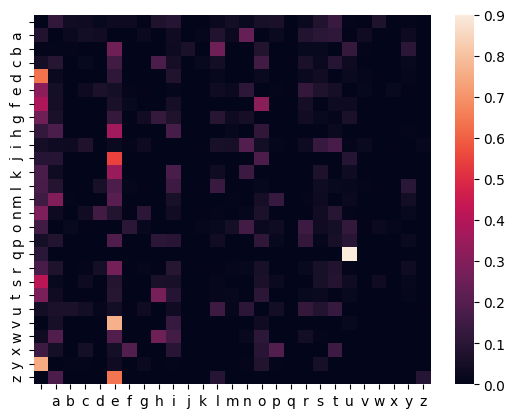

In [22]:
ax = sns.heatmap(Pij, linewidth=0, xticklabels=text_1_char_index_map.keys(), yticklabels=text_1_char_index_map.keys())#, annot=True)
plt.show()

### (2b) Na základě matice z předchozího bodu najděte stacionární rozdělení π tohoto řetězce pro první text.

Hledame tedy takovy retezec, aby platilo

$\pi = P * \pi$


(Puvodne jsem se tady celkem dlouho delal s tim, ze jsem si to spatne odvodil na $\pi = (P - I)^{-1}$ a pocital v pripade ze (p-I) je regularni. Bohuzel neumim vytykat matice od vektoru, tak smazano :cry:  )

Jelikoz matice P vznikla ze samotneho rozdeleni znaku (ve skutecnosti samozrejme ze dvojic pismen a ne ze samostatnych pismen), tak zkusim overit stacionarni podminku $\pi = P * \pi$ pro rozdeleni znaku v textu.

Ziskam si tedy rozdeleni znaku z 1. textu

In [23]:
# copy pasted from 1./2. HW
def calc_char_probabilities(text: str):
    list_of_characters = [*text]
    total_characters_count = len(list_of_characters)
    char_counter = Counter(list_of_characters)
    char_probabilities = {}
    for c, n in sorted(char_counter.items()):
        char_probabilities[c] = n/total_characters_count
    return char_probabilities
file_1_chars_prob = calc_char_probabilities(text_1)
file_1_chars_prob_arr = np.array(list(file_1_chars_prob.values()))

In [24]:
file_1_chars_prob_arr

array([0.17706756, 0.06710088, 0.01438958, 0.02408361, 0.02696153,
       0.10133293, 0.01454105, 0.01438958, 0.04937898, 0.06437443,
       0.00166616, 0.00439261, 0.03620115, 0.0212057 , 0.05786125,
       0.05543775, 0.02226598, 0.00151469, 0.04513784, 0.0566495 ,
       0.07376553, 0.0236292 , 0.00833081, 0.01696456, 0.00318085,
       0.01651015, 0.00166616])

Kontrola podminky stacionarity - $\pi = P * \pi$

In [25]:
np.linalg.norm(file_1_chars_prob_arr - np.dot(Pij, file_1_chars_prob_arr))

0.3369992244716208

F norma rozdilu / "velikost chyby" = 0.33. Na numerickou chybu to je moc. Vzhledem k tomu, ze je zde 27 prvku/chlivecku tak to "neni tak spatne" (ano, soucet musi porat davat 1, takze z jineho pohledu stale daleko).

Napisu si iterativni algoritmus pro "doladeni" hodnoty $\pi$. Vyuziju faktu, ze z prednasky vime, ze toto $\pi_t = P * \pi_{t-1}$ by melo konvergovat do stacionarniho rozdeleni.

In [26]:
pi_prev = file_1_chars_prob_arr
for i in range(0, 100):
    pi_new = np.dot(Pij, pi_prev)
    if i % 10 == 0:
        print(f"iter {i}, {np.linalg.norm(pi_new - np.dot(Pij, pi_new))}")
    # print(f"iter {i}, {np.linalg.norm(pi_new - np.dot(Pij, pi_new))}")
    pi_prev = pi_new

iter 0, 0.15880042630399327
iter 10, 7.138786587397818e-07
iter 20, 1.148043786647615e-11
iter 30, 1.5328517645723046e-16
iter 40, 0.0
iter 50, 0.0
iter 60, 0.0
iter 70, 0.0
iter 80, 0.0
iter 90, 0.0


"Chyba" zkonvergovala primo do 0 po 34 iteracich

In [27]:
pi_new

array([0.07524056, 0.07524056, 0.07524056, 0.07524056, 0.07524056,
       0.07524056, 0.07524056, 0.07524056, 0.07524056, 0.07524056,
       0.07524056, 0.07524056, 0.07524056, 0.07524056, 0.07524056,
       0.07524056, 0.07524056, 0.07524056, 0.07524056, 0.07524056,
       0.07524056, 0.07524056, 0.07524056, 0.07524056, 0.07524056,
       0.07524056, 0.07524056])

Overim si podminku souctu pravdepodobnosti

In [28]:
np.sum(pi_new)

2.031495018174551

!= 1. Zkusim vydelit timto souctem a nasledne opet overit stacionaritu

In [29]:
# a_normed_pi_new = pi_new / np.linalg.norm(pi_new)
a_normed_pi_new = pi_new / np.sum(pi_new)

In [30]:
np.sum(a_normed_pi_new)

0.9999999999999998

In [31]:
np.linalg.norm(a_normed_pi_new - np.dot(Pij, a_normed_pi_new))

2.3013707539344673e-17

In [32]:
a_normed_pi_new

array([0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704, 0.03703704, 0.03703704, 0.03703704,
       0.03703704, 0.03703704])

`a_normed_pi_new` je tedy stacionarni rozdeleni. 
Plati:

- soucet prvku = 1

- $\pi = P * \pi$

- vsechny prvky jsou nezaporne

In [33]:
pi = a_normed_pi_new

### (2b) Porovnejte rozdělení znaků druhého textu se stacionárním rozdělením π, tj. na hladině významnosti 5 % otestujte hypotézu, že rozdělení znaků druhého testu se rovná rozdělení π z předchozího bodu.

In [34]:
alpha = 0.05

Pro toto otestovani pouziju test dobre shody $\chi^2$ pro zname parametry. $\pi$ si vyberu jako to zname rozdeleni s pravdepodobnostmi $p_1, ... p_k$ a budu zkoumat, zda-li se mu rovna rozdeleni p' znaku z 2. textu s cetnostmi $N_1, ... N_k$.

Hypozy zformuluji jako:
$H_0: \pi = p2$ a $H_a: \pi \ne p2$

![df](hypotezA_chi2.png)

ve screenshotu z handoutu, si za `p` dosadim $\pi$

`k` bude v tomto pripade pocet unikatnich znaku (z 1. textu, ale musi se rovnat i z textu 2)

In [35]:
k = len(file_1_chars_counts)
k

27

In [36]:
# check char counts from both texts. Already done above, but just to be sure, keep it here
len(file_1_chars_counts) == len(file_2_chars_counts)

True

Jako `n` si vezmu pocet vsech vsech znaku z 2.textu 

In [37]:
n = len(text_2)
n

5028

Cetnosti $N_1, ..., N_k$ si dam do numpy vektoru pro zjednoduseni implementace nasledujicich poctu

In [38]:
# file_2_chars_counts
Ni = np.array(list(file_2_chars_counts.values()))
Ni

array([1009,  343,   67,   74,  181,  478,   76,   85,  281,  264,    5,
         47,  172,   74,  263,  313,   61,    2,  213,  246,  418,  115,
         34,  131,    1,   73,    2])

Spocitam si teoreticke cetnosti z $n*\pi_i$

In [39]:
npi = n * pi
npi

array([186.22222222, 186.22222222, 186.22222222, 186.22222222,
       186.22222222, 186.22222222, 186.22222222, 186.22222222,
       186.22222222, 186.22222222, 186.22222222, 186.22222222,
       186.22222222, 186.22222222, 186.22222222, 186.22222222,
       186.22222222, 186.22222222, 186.22222222, 186.22222222,
       186.22222222, 186.22222222, 186.22222222, 186.22222222,
       186.22222222, 186.22222222, 186.22222222])

(Vsechny teoreticke cetnosti jsou vetsi nez 5, nemusim tedy mergovat hodnoty. U namerenych cetnosti jsou sice nektere mensi 5, ale tam nas to nezajima.)

Nyni si muzu doplnit do statistiky

In [40]:
Chi2 = np.sum(np.square(Ni - npi)/npi)
Chi2

6217.918854415277

A kriticka hodnota

In [41]:
chi2 = st.chi2.isf(alpha,k-1)
chi2

38.88513865983007

Kriticky obor je $\chi^2 \ge \chi^2_{\alpha, k-1}$, co je splneno vyslednymi hodnotami.

Zamitame tedy hypotezu $H_0$ ve prospech $H_a$ na hladine 5%. To znamena ze rozdeleni znaku z 2. textu neni stejne jako $\pi$ rozdeleni (stacionarni rozdeleni pro 1. text) opet na hladine 5%.

